## Examine cost measure heuristic induced by naive embedding of the 8-puzzle state space on the sphere $\mathbb{S}^9$

Some relevant plots to pique the interest

induced heuristic with mean centering | induced heuristic with goal centering 
- | -
![example of induced heuristic with mean centering](plt1.png "plot 1")|![example of induced heuristic with goal centering](plt2.png "plot 2")

In [3]:
import numpy as np

# helper function
def euc_dist(v1,v2):
    
    assert len(v1) == len(v2)
    
    square_diffs = [(v1[i] - v2[i])**2 for i in range(len(v1))]
    return np.sqrt(sum(square_diffs))
    
def mink_dist(v1,v2):
    
    assert len(v1) == len(v2)
    
    abs_diffs = [np.abs(v1[i] - v2[i]) for i in range(len(v1))]
    return sum(abs_diffs)

$s$ is a generic initial state from $\Theta$ (corresponding to a specific configuration as described in my write up) embedded into $\mathbb{R}^{3 \times 3} \cong \mathbb{R}^9$. 

Similarly, $g$ is the embedded goal state.

In [4]:
s = np.array([0,4,2,1,3,5,6,8,7])
g = np.array(list(range(9))) # goal state

print('Euclidean distance:', euc_dist(s,g))
print('Minkovsky distance:', mink_dist(s,g))

Euclidean distance: 4.0
Minkovsky distance: 8


### Define the sphere map $\phi^{-1}$ which embeds Euclidean space $\phi^{-1}:\mathbb{R}^n \hookrightarrow \mathbb{S}^n$ into the $n$-sphere via stereographic projection. Define the induced metric $h_g(s)$ where $\psi : \Theta \to \mathbb {R}^n$ is the embedding of the configuration space
$$
h_g(s) := \frac{1}{\pi} \| \phi^{-1} \circ \psi (s) - \phi^{-1} \circ \psi (g) \|_{\text{geodesic}}
$$

In [5]:
def sphere_map(x):
    
    scale = 1 / (1 + euc_dist( [0]*len(x), x) ** 2)
    
    temp_y = [2*t for t in x]
    temp_y += [1 - euc_dist( [0]*len(x), x) ** 2]
    y = np.array([scale * t for t in temp_y ])
    
    return y

def h(s, target=g): # induced metric on the sphere
    
    h = np.arccos( np.dot( sphere_map(s), sphere_map(target) ) ) / np.pi
    return h


We discussed that $h_g (s)$ could be defined in a different way, if we were able to enumerate and evaluate the possible states
$$
h_g(s) := \frac{\| \phi^{-1} \circ \psi (s) - \phi^{-1} \circ \psi (g) \|_{\text{geodesic}}}
{ \min_{s \in \Theta} \| \phi^{-1} \circ \psi (s) - \phi^{-1} \circ \psi (g) \|_{\text{geodesic}} } 
$$

In [6]:
import itertools
all_states = list(itertools.permutations(list(range(9))))
all_costs = [ np.arccos( np.dot( sphere_map(s), sphere_map(g) ) ) for s in all_states ]

eta = max(all_costs)
eta

0.15128504247484439

In this case we would find for $\eta = \min_{s \in \Theta} \| \phi^{-1} \circ \psi (s) - \phi^{-1} \circ \psi (g) \|_{\text{geodesic}} = 0.15128504247484367$

In [7]:
print('configuration s embedded on the 9-sphere:', "\n", sphere_map(s), '\n'*2+'goal g embedded on the 9 sphere:', '\n', sphere_map(g), '\n')

print('induced heuristic cost of s:', h(s))

configuration s embedded on the 9-sphere: 
 [ 0.          0.03902439  0.0195122   0.0097561   0.02926829  0.04878049
  0.05853659  0.07804878  0.06829268 -0.9902439 ] 

goal g embedded on the 9 sphere: 
 [ 0.          0.0097561   0.0195122   0.02926829  0.03902439  0.04878049
  0.05853659  0.06829268  0.07804878 -0.9902439 ] 

induced heuristic cost of s: 0.0124226375717


### Evolving states towards goal
I think it would be interesting to see how this cost evolves compared with euclidean distance, if we were to evolve the initial state to the goal state along a smooth (linearly interpolated) trajectory.

In [8]:
from scipy.interpolate import interp1d

def evolv_cost(s,g, scale=100):
    """
    scale = granularity of the interpolation (number of generated data points)
    note: fix to have this return the t dataset automatically
    """
    
    linfit = interp1d([0,1], np.vstack([s,g]), axis=0)
    alpha = scale#200
    t = np.array(list(range(alpha+1)))/alpha
    sequence = linfit(t)
    g = np.reshape(g, newshape=(9,1))
    cost_sphere = np.array([ h( sequence[i:i+1][0], target = g ) for i in range(alpha+1) ])
    cost_euclid = np.array([ euc_dist( sequence[i:i+1][0], g ) for i in range(alpha+1) ])

    return cost_sphere, cost_euclid


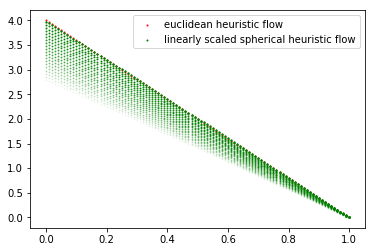

In [9]:
import matplotlib.pyplot as plt

alpha = 100
t = np.array(list(range(alpha+1)))/alpha

cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)
plt.scatter(t, cost_euclid, s=1, color='red')

scaling_coeff = 320 
# empirically determined in this case. 
# used to compare cost based on euclidean heuristic vs spherical heuristic

plt.scatter(t, scaling_coeff*cost_sphere, s=1, color='green')

labels = ('euclidean heuristic flow','linearly scaled spherical heuristic flow')
plt.legend(labels,loc ='best')

for i in range(20):
    plt.scatter(t, (scaling_coeff - 5*i)*cost_sphere, s=1, color='green', alpha=1-i/20)
    
# plt.scatter(t, cost_sphere, s=1, color='blue')
plt.show()

The gradient green curves indicate the spherical heuristic flow at different scalings. We can examine the difference between euclidean and spherical heuristics: 


In [10]:
temp = []

for k in range(500):
    temp.append(euc_dist(cost_euclid, k*cost_sphere))

minimizing_scaling = temp.index(min(temp))

print('a few examples:' + '\n'+ 'for s = '+ str(s) +', scaling = ' + str(minimizing_scaling) + ' minimizes error to ' + str(min(temp)[0]))
print('for s = [8 7 5 6 3 4 1 0 2], scaling = 292 minimizes error to 4.61657357')

a few examples:
for s = [0 4 2 1 3 5 6 8 7], scaling = 320 minimizes error to 0.0731690682409
for s = [8 7 5 6 3 4 1 0 2], scaling = 292 minimizes error to 4.61657357


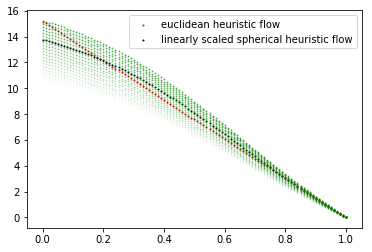

In [11]:
# comparison

s = [8, 7, 5, 6, 3, 4, 1, 0, 2]

alpha = 100
t = np.array(list(range(alpha+1)))/alpha

cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)
plt.scatter(t, cost_euclid, s=1, color='red')

scaling_coeff = 292 
plt.scatter(t, scaling_coeff*cost_sphere, s=1, color='black')

labels = ('euclidean heuristic flow','linearly scaled spherical heuristic flow')
plt.legend(labels,loc ='best')

scaling_coeff = 323 # again empirically determined to give range in graph
for i in range(20):
    plt.scatter(t, (scaling_coeff - 5*i)*cost_sphere, s=1, color='green', alpha=.5*(1-i/20))
    
plt.show()

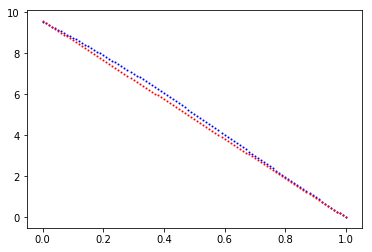

In [12]:
# another quick example

s_prime = np.array([1,5,6,0,4,7,3,8,2])
h(s_prime)
cost_sphere, cost_euclid = evolv_cost(s_prime,g)

plt.scatter(t, 320*np.array(cost_sphere), s=1, color='blue')
plt.scatter(t, np.array(cost_euclid), s=1, color='red')
plt.show()

### Idea - randomly sample from starting locations and look at the distribution and evolution of spherical cost

We randomly sample $s$ from $\Theta$ and examine the resulting evolution of spherical cost.

In [13]:
simulation_size = 500

num_examples = 20

# dist_scale_coef = 320

scaling_factors = []
diffs = []

selected_indices=np.random.choice(a = range(simulation_size), size = num_examples, replace=False)

selected_data = []
unusual_examples = [] # rewrite how these are selected

for k in range(simulation_size):
    
    initial_configuration = np.random.choice( a=list(range(9)),size=(9,),replace=False )
    
    cost_sphere, cost_euclid = evolv_cost(initial_configuration,g)

    eps = 0.00001 # avoid divide by 0 numerical issues as both euclid and spherical cost -> 0 as 'time' -> 1

    _scale = np.mean( [ (cost_euclid[i] + eps) / (cost_sphere[i] + eps) for i in range(10, len(cost_sphere) - 10)] ) # 10 bumps away from edge cases where both go to 0
    scaling_factors.append(_scale) # measures linearity of relationship between spherical and euclidean cost evolution
    
#     scaled_cost_sphere = dist_scale_coef * cost_sphere
    scaled_cost_sphere = _scale * cost_sphere
    
    if (_scale > 315) | (_scale < 285): unusual_examples.append(initial_configuration) # interesting so save
    
    discrepancy = euc_dist(scaled_cost_sphere , cost_euclid)
    diffs.append(discrepancy)
    
    if k in selected_indices:
        selected_data.append([ k, [ initial_configuration, cost_sphere, cost_euclid ] ])

## printing out basic info about diffs
print('discrepancy between euclidean and spherical:')
upper = np.mean(diffs) + 2 * np.std(diffs)
lower = np.mean(diffs) - 2 * np.std(diffs)
print('lower:', lower, 'upper:', upper, 'mean:', np.mean(diffs))

print('\n')

## printing out basic info about scale / linearity
print('statistics about linear scaling:')
upper = np.mean(scaling_factors) + 2 * np.std(scaling_factors)
lower = np.mean(scaling_factors) - 2 * np.std(scaling_factors)
print('lower:', lower, 'upper:', upper, 'mean:', np.mean(scaling_factors))

print('\n')

print("number of relatively 'unusual' examples:", len(unusual_examples))

discrepancy between euclidean and spherical:
lower: -0.0485281279721 upper: 3.98617532389 mean: 1.96882359796


statistics about linear scaling:
lower: 288.713245111 upper: 316.397748953 mean: 302.555497032


number of relatively 'unusual' examples: 20


We can examine a few randomly selected examples from the simulation. Here sphericial cost is scaled by the average scaling constant over the heuristic evolution *on each individual example's scale* (so scaling coefficient(s) vary over examples)

19 indexed at : 0


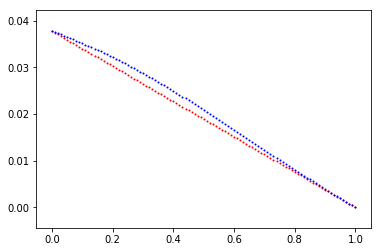

84 indexed at : 1


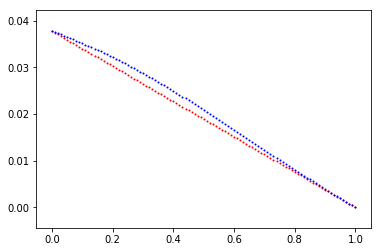

In [14]:
budget = 2
# this is the number of plots you're willing to look at
# should put these in a plot matrix at some point

for item in selected_data[0:budget]:
    
    _id = item[0]
    initial_state = item[1][0]

    cost_sphere = item[1][1]
    cost_euclid = item[1][2]

    print(_id , 'indexed at :', selected_data.index(item))
    
    
    # examine just sphere cost
    num_points = len(cost_sphere)
    lin_comparison = np.linspace(cost_sphere[0], cost_sphere[num_points-1], num_points)
    
    alpha = 100 # default scale used in evolv_cost for previous simulation
    t = np.array(list(range(alpha+1)))/alpha
    
    plt.scatter(t, lin_comparison, s=1, color='red')
    plt.scatter(t, cost_sphere, s=1, color='blue')

    # examine sphere cost vs euclidean dist
#     plt.scatter(t, 320*np.array(cost_sphere), s=1, color='blue')
#     plt.scatter(t, np.array(cost_euclid), s=1, color='red')
    plt.show()

deviation from linearity: 0.000476848717878


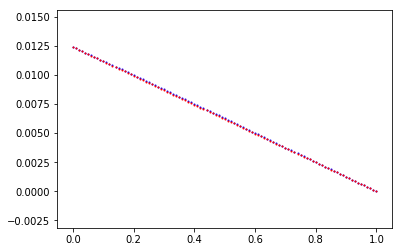

In [15]:
# homework example

s = np.array([0,4,2,1,3,5,6,8,7])

alpha = 100
cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, cost_sphere, s=1, color='blue')
lin_comparison = np.linspace(cost_sphere[0], cost_sphere[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')

print("deviation from linearity:", euc_dist(lin_comparison, cost_sphere)[0] )

plt.show()

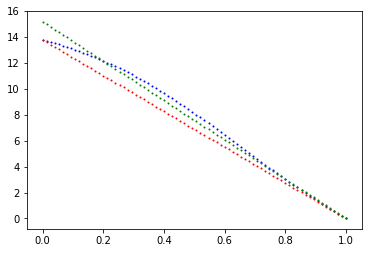

In [16]:
# interesting configuration

another_config = unusual_examples[0] 
another_config = [0, 1, 4, 5, 3, 2, 7, 6, 8] # saved from a previous sample

interesting_config = selected_data[4][1][0] # from looking at plots above, selecting an interesting one
interesting_config = [8, 7, 5, 6, 3, 4, 1, 0, 2] # saved from previous sample

# plot from above config

s = interesting_config

alpha = 75
cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)

# scaling
temp = []
for k in range(500):
    temp.append(euc_dist(cost_euclid, k*cost_sphere))
min_scaling = temp.index(min(temp))
scaled_cost_sphere = min_scaling*cost_sphere

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, scaled_cost_sphere, s=1, color='blue')
lin_comparison = np.linspace(scaled_cost_sphere[0], scaled_cost_sphere[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')

plt.scatter(t, cost_euclid, s=1, color='green')

plt.show()

## Effect of Centering 

i.e., examine the importance of the embedding of the state space $\Theta$ into the sphere $\mathbb{S}^9$ upon determining heuristic evolution.

In [17]:
def center(x, _type=1): # assume a state from 8-puzzle
    
    """
    centers based on x - µ (type I)
    or based on x - g (type II) (so that g is sent to origin and hence to a pole in sphere embedding)
    """
    
#     assert type(x) == numpy.ndarray
    
    ## this will give same results
    #_max = 8
    #_min = 0
    #center = (_max - _min) / 2 # = 4 for s in Theta
    ##
    
    if _type==1: center = np.mean(x) # turns out this = 4 for s in Theta
    if _type==2: center = g # g = global variable, goal state embedded into R^9

    
    return x - center

def decenter(x,_type=1): # we might as well have a simple way to decenter based on the specific game
    """
    based on the dimension of x
    assume flat input (for the moment)
    add capacity to decenter for diff types of centering
    """
    
    dims = x.shape
    limit = dims[0]
    
    center_coeff = np.mean(range(limit))
    
    return x + center_coeff
    

print('\n' + "' * "*3 + 'Type I centering' + " * '"*3 + '\n' )
print('centered s:', center(s), '\ndecentered:', decenter(center(s)), '\noriginal s:', s)
print('centered g:',center(g))
# print('centered configuration:',center(interesting_config))
print('\n' + "' * "*3 + 'Type II centering' + " * '"*3 + '\n' )
print('centered s:', center(s, _type=2))
print('centered g:',center(g, _type=2))


' * ' * ' * Type I centering * ' * ' * '

centered s: [ 4.  3.  1.  2. -1.  0. -3. -4. -2.] 
decentered: [ 8.  7.  5.  6.  3.  4.  1.  0.  2.] 
original s: [8, 7, 5, 6, 3, 4, 1, 0, 2]
centered g: [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

' * ' * ' * Type II centering * ' * ' * '

centered s: [ 8  6  3  3 -1 -1 -5 -7 -6]
centered g: [0 0 0 0 0 0 0 0 0]


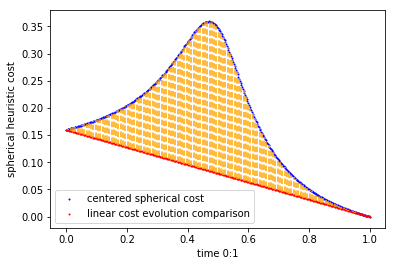

In [18]:
# quick examples

s = np.array([0, 4, 2, 1, 3, 5, 6, 8, 7])
s = interesting_config
centered_s = center(s)
centered_g = center(g)

alpha = 400

cost, _ = evolv_cost(s,g, scale=alpha)
centered_cost, _ = evolv_cost(centered_s,centered_g, scale=alpha)

# num_points = len(cost_sphere) # just use alpha

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, centered_cost, s=1, color='blue')
lin_comparison = np.linspace(centered_cost[0], centered_cost[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')

labels = ('centered spherical cost','linear cost evolution comparison')
plt.legend(labels,loc ='best')


# plt.scatter(t, np.array(cost), s=1, color='blue')


# # fill in plot difference HORIZONTAL - only visible if nonlinear
# fill_increment = 2
# denseness = 3 # closer to 1 is denser
# for i in range(1, int(alpha/denseness) - 1):
    
#     _index = denseness*i
#     x = t[_index + fill_increment] # makes horiz lines start within line boundaries
#     y = lin_comparison[_index]
    
#     # get x where horizontal line passes centered_cost:
#     ##
#     k = _index
#     while centered_cost[k] > y:
#         k+=fill_increment
#     ##
#     new_x = t[k-fill_increment] 
#     plt.plot( [x,new_x],[y,y], linestyle='dashed', color='orange' )



# fill in plot difference VERTICAL - only visible if nonlinear
denseness = 3 # closer to 1 is denser
for i in range(1, int(alpha/denseness) - 1):
    
    _index = denseness*i
    x = t[_index] 
    y = lin_comparison[_index]
    new_y = centered_cost[_index]
    
    plt.plot( [x,x],[y,new_y], linestyle='dashed', color='orange' )


plt.xlabel("time 0:1")
plt.ylabel("spherical heuristic cost")

# save to display later
plt.savefig('plt1.png', dpi=500)

plt.show()
plt.close()  

### Explanation

After centering, we see that evolving the state now has the effect of potentially tracing out a path over the unit sphere, however depending on the configuration, it's possible that moving linearly towards the goal might begin looping the corresponding spherical arc indirectly –– here we see the image of embedded state in the sphere at first moves indirectly, even away from the image of the goal, until rounding some portion (probably crosing an axis to a different 'octant' allows the curve to then approach the goal more directly.


Let's repeat the above example but with 'goal-centric' centering
### Goal Centering

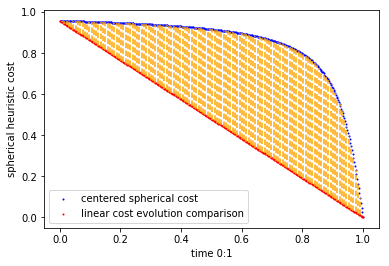

In [19]:
# quick example

s = np.array([0, 4, 2, 1, 3, 5, 6, 8, 7])
s = interesting_config
centered_s = center(s, _type=2)
centered_g = center(g, _type=2)

alpha = 400

cost, _ = evolv_cost(s,g, scale=alpha)
centered_cost, _ = evolv_cost(centered_s,centered_g, scale=alpha)

# num_points = len(cost_sphere) # just use alpha

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, centered_cost, s=1, color='blue')
lin_comparison = np.linspace(centered_cost[0], centered_cost[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')


labels = ('centered spherical cost','linear cost evolution comparison')
plt.legend(labels,loc ='best')


# fill in plot difference VERTICAL - only visible if nonlinear
denseness = 3 # closer to 1 is denser
for i in range(1, int(alpha/denseness)):
    
    _index = denseness*i
    x = t[_index] 
    y = lin_comparison[_index]
    new_y = centered_cost[_index]
    
    plt.plot( [x,x],[y,new_y], linestyle='dashed', color='orange' )


plt.xlabel("time 0:1")
plt.ylabel("spherical heuristic cost")

# save to display later
plt.savefig('plt2.png', dpi=500)

plt.show()
plt.close()  

Here we see somewhat contrasting result –– by centering with respect to the goal point, this has the effect of mapping the embedded goal state onto one of the poles of the sphere. potentially then, the image of the path from state to goal mapped onto the sphere may be stretched over a greater surface area based on distortion from mapping euclidean space onto the upper hemisphere of $\mathbb{S}^9$.

## Comparison of Centering's effects on heuristic flow, and distribution of 'best linear error' 

Return to the case of the embedded state $\psi(s) = [8, 7, 5, 6, 3, 4, 1, 0, 2]$

In [20]:
# states
s = np.array([8, 7, 5, 6, 3, 4, 1, 0, 2])
g = np.array(list(range(9)))

# centering
Zs_1 = center(s, _type=1)
Zs_2 = center(s, _type=2)
Zg_1 = center(g, _type=1)
Zg_2 = center(g, _type=2)


alpha = 400
t = np.array(list(range(alpha+1)))/alpha


cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)
z1_sphere, z1_euclid = evolv_cost(Zs_1,Zg_1, scale=alpha)
z2_sphere, z2_euclid = evolv_cost(Zs_2,Zg_2, scale=alpha)

# scale factor
temp = []
for k in range(1,600):
    temp.append([euc_dist(cost_euclid, k*cost_sphere), 
                 euc_dist(z1_euclid, k*z1_sphere), 
                 euc_dist(z2_euclid, k*z2_sphere)])

min_scaling_coeff = [ temp.index(min(temp, key = lambda tup: tup[i])) for i in range(3) ]
min_scaling_coeff

sphere_data = [cost_sphere, z1_sphere, z2_sphere]
euclid_data = [cost_euclid, z1_euclid, z2_euclid]

In [21]:
# # test
# i=0
# min_scaling_coeff[i]

# for j in range(1,400):
#     if euc_dist(sphere_data[i] * j , euclid_data[i]) < 10: print(j)
    
# print(min_scaling_coeff[i])

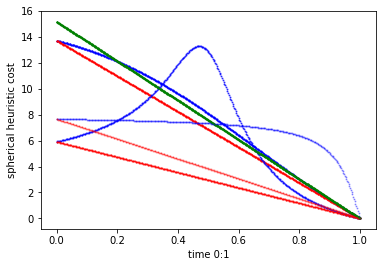

In [22]:

for i in range(3):
    alpha_i = 1 - i/3
    plt.scatter(t, min_scaling_coeff[i]*sphere_data[i], s=1, color='blue', alpha = alpha_i)
    lin_comparison = np.linspace(min_scaling_coeff[i]*sphere_data[i][0], min_scaling_coeff[i]*sphere_data[i][alpha], alpha+1)
    plt.scatter(t, lin_comparison, s=1, color='red', alpha = alpha_i)
    plt.scatter(t, euclid_data[i], s=1, color='green', alpha = alpha_i)



# labels = ('centered spherical cost','linear cost evolution comparison')
# plt.legend(labels,loc ='best')


# denseness = 3 # closer to 1 is denser
# for i in range(1, int(alpha/denseness)):
    
#     _index = denseness*i
#     x = t[_index] 
#     y = lin_comparison[_index]
#     new_y = centered_cost[_index]
    
#     plt.plot( [x,x],[y,new_y], linestyle='dashed', color='orange' )


plt.xlabel("time 0:1")
plt.ylabel("spherical heuristic cost")

# # save to display later
# plt.savefig('plt2.png', dpi=500)

plt.show()
plt.close()  

Note the centering transformations, which are isometries, leave the euclidean flow unaffected (there is only a signle green plot of the euclidean flow)

In [23]:
np.mean( [euc_dist( min_scaling_coeff[i]*sphere_data[i] , euclid_data[i] ) for i in range(3)] )

52.951945288785367

In [24]:
# distribution of errors between scaled spherical heuristic and euclidean heuristic flows


In [25]:
# comparison of spherical heuristic (centered vs non-centered)

simulation_size = 500
diffs = []

for k in range(simulation_size):
    
    initial_configuration = np.random.choice( a=list(range(9)),size=(9,),replace=False )
    cost_sphere, cost_euclid = evolv_cost(initial_configuration,g) # scale=alpha

    temp = []
    for k in range(150,400):
        temp.append(euc_dist(cost_euclid, k*cost_sphere))
    minimizing_scaling = temp.index(min(temp))
    
    scaled_cost_sphere = minimizing_scaling * cost_sphere
    discrepancy = euc_dist(scaled_cost_sphere , cost_euclid)
    diffs.append(discrepancy)
    

## printing out basic info about diffs
print('discrepancy between euclidean and spherical:')
upper = np.mean(diffs) + 2 * np.std(diffs)
lower = np.mean(diffs) - 2 * np.std(diffs)
print('lower:', lower, 'upper:', upper, 'mean:', np.mean(diffs))

discrepancy between euclidean and spherical:
lower: 17.9653903707 upper: 43.9534014411 mean: 30.9593959059


### Estimate pdf and cdf of distribution of minimum-error between euclidean and spherical  heuristic evolution

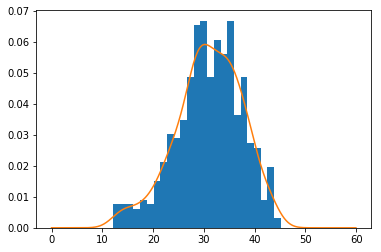

In [26]:
from scipy.stats import gaussian_kde

# pdf


diffs_ = [ x[0] for x in diffs ] # strip dataset to list [...] form

max_val = 60
granularity = 20
num_data = max_val*granularity
x_range = np.array(range(num_data)) / granularity

kde = gaussian_kde(diffs_)
pdf = kde.pdf
plt.hist(diffs_, bins = 25, density=True)
plt.plot(x_range, pdf(x_range))

plt.show()

In [27]:
margin = 0.5 * np.std(diffs_)
low_bounds = np.mean(diffs_) - margin
high_bounds = np.mean(diffs_) + margin
maxpts = 100

interval_portion = kde.integrate_box(low_bounds=low_bounds, high_bounds=high_bounds, maxpts=maxpts)

print( str(100*interval_portion) + '% lie within [' + str(low_bounds) + ', ' + str(high_bounds)) 

37.084402232008976% lie within [27.7108945221, 34.2078972897


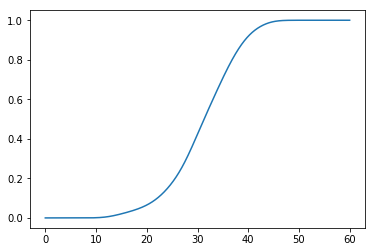

In [29]:
# cdf

low_bounds = np.zeros(shape=(num_points,))
high_bounds = np.array(range(num_points))/granularity
maxpts = 100*granularity

max_inpt = 60
granularity = 100
num_points = max_inpt * granularity

cdf = []

for i in range(num_points):   
    cdf.append(kde.integrate_box(low_bounds=low_bounds[i], high_bounds=high_bounds[i], maxpts=maxpts))


plt.plot(high_bounds, cdf)
plt.show()

# Greedy Search

### A more realistic measure

One issue with the comparisons carried out before is that linearly evolving states towards the goal is inconsistent with the constraints imposed on the game. I construct a method for evolving states only through allowable manuevers below, to make it more realistic. 

In [30]:
### make it more realistic...

def state(s):
    """
    This creates a 2d array representation of the states (visual clarity)
    These representations are used to feed into the move_map generator for finding allowable moves 
    (again, this form used to reinforce intuition)
    """
    
    dim = np.sqrt(s.shape[0])
    assert dim == int(dim) == 3 # it's a square number. for my problem should be 3
        
    temp_s = np.reshape(s, newshape=(int(dim),int(dim)) )
    return temp_s

def move_map(s, state_cache, debug_flag = False):
    """
    takes in a state s. 
    finds allowable moves from s based on:
        swaps coordinates but only those that are adjacent to '0'
    state_cache - to remove previous state from generated list
    """
    
    assert s.shape == (3,3) # check it's in an allowable form. This is the only part hard-coded to the '8-puzzle' space
    zero_index = np.where(s == 0)
    zero_index = np.reshape(zero_index, newshape=(1,2))[0] # so that zero_index = [i,j] without array gunk
    
    # find possible moves
    i = zero_index[0]
    j = zero_index[1]


    pos_j = [j-1, j, j+1]
    pos_i = [i-1, i, i+1]
 
    
    ##   o   X  o
    ##   X  ij  X
    ##   o   X  o
    ##
    ##  Allowed moves (center is current location)
    ##  Note all indices below sum to 1 mod 2.
        
#     pos_indices = np.array( 
#         [[pos_i[0] , pos_j[1]]] + [[pos_i[1] , pos_j[k]] for k in [0, 2]] + [[pos_i[2] , pos_j[1]]]
#     ) 
    pos_indices = [[pos_i[0] , pos_j[1]]] + [[pos_i[1] , pos_j[k]] for k in [0, 2]] + [[pos_i[2] , pos_j[1]]]
    
    
    pos_indices = [ z for z in pos_indices if (z[0] >= 0) & (z[1] >= 0) & (z[0] < 3) & (z[1] < 3) ] # assume dim 3 x 3
    
    # state_cache[-1] = current state
    if len(state_cache) < 2: # first round
        move_pairs = [[zero_index , index] for index in pos_indices]
        
        if debug_flag: print('first round, current options:', move_pairs)

    else: # not first round

        previous_zero_index = [x[0] for x in np.where(state_cache[-2] == 0)] 
        move_pairs = [[zero_index , index] for index in pos_indices if index != previous_zero_index]

        if debug_flag: 
            print('previous states:', state_cache[-3:])
            print('prev zero:', previous_zero_index)
            print('current options:', move_pairs)
    
    return move_pairs

def evaluate_moves(s,move_pairs, h):
    """
    s = current state (in square form = output of state(s))
    move pairs = set of possible moves { [current, other1], [current, other2], ... }
    h = heuristic for evaluating moves
    """
    
    init_state = np.copy(s)
    
    local_costs = []
    
    for pair in move_pairs:
                
        s = init_state # make sure to reset s after changing

        
        init_coord = pair[0]
        next_coord = pair[1]
        
        start_tup = init_coord[0],init_coord[1]
        destination_tup = next_coord[0],next_coord[1]


        start = s[start_tup]
        target = s[destination_tup]
        
        # swap
        s[destination_tup] = start
        s[start_tup] = target
    
        
        flattened_s = s.flatten()        
        cost = h(flattened_s)
        
        local_costs.append(cost)
            
            
    s = init_state
    
    return local_costs
    
def select_move(s, move_pairs, local_costs, cost_cache, state_cache, debug_flag = False):
    """
    perform move
    s = current state
    state_cache = list of previous states 
        ensure you don't select the state you were in during the previous time step
        add updated state to cache
    .
    .
    .
    """
    
    next_state = np.copy(s) #before applying selected move
    
    min_index = local_costs.index(min(local_costs))
    move_cost = local_costs[min_index]
    cost_cache.append(move_cost)
    move = move_pairs[min_index]
    
    if debug_flag: print("selected move:", move)
    
    # move
    init_coord = move[0]
    next_coord = move[1]

    start_tup = init_coord[0],init_coord[1]
    destination_tup = next_coord[0],next_coord[1]


    start = next_state[start_tup]
    target = next_state[destination_tup]

    # swap
    next_state[destination_tup] = start
    next_state[start_tup] = target
    
    if debug_flag: print('state after move performed:', next_state)

    state_cache.append(next_state)
    
    return next_state, cost_cache, state_cache
    
    

In [31]:
# example troubleshooting code (debug_flag default off)

cost_cache = []
temp_s = state(s)
state_cache = [temp_s]

print('initial state:\n', temp_s)

for i in range(3):

    temp = move_map(temp_s, state_cache)
    temp
    costs = evaluate_moves(temp_s, temp, h)
# costs
    temp_s, cost_cache, state_cache = select_move(temp_s, temp, costs, cost_cache, state_cache)
    print('next state:\n', temp_s)


initial state:
 [[8 7 5]
 [6 3 4]
 [1 0 2]]
next state:
 [[8 7 5]
 [6 0 4]
 [1 3 2]]
next state:
 [[8 7 5]
 [6 4 0]
 [1 3 2]]
next state:
 [[8 7 5]
 [6 4 2]
 [1 3 0]]


In [44]:
## THOUGHTS - -USE CENTERING and WRITE UPDATE FUNCTION

# goal state is g

def evolve_game(s, h, max_budget, centered = True):
    
    goal = g
    
    # read in state
    if centered: temp_s , goal = state(center(s)) , state(center(goal))
    else: temp_s = state(s)

    state_cache = [s]
    cost_cache = []
    
    count = 1

    print('initial \n' , temp_s)
    cost_decreasing = True #initialize to true to include filter

#     while cost_decreasing & (count < max_budget): # could have it go till cost_cache is not decreasing
   
    while (temp_s != goal)&(count < max_budget): # could have it go till cost_cache is not decreasing

        temp = move_map(temp_s, state_cache)
    #     print(temp)
        costs = evaluate_moves(temp_s, temp, h)
        temp_s, cost_cache, state_cache = select_move(temp_s, temp, costs, cost_cache, state_cache)
        
#         print(temp_s.flatten()) # debug
        
        count+=1
        
#         if count > 2:
#             cost_decreasing = cost_cache[-1] < cost_cache[-2]


###
###
###

    print('final \n', temp_s)
    
    x = list(range(len(cost_cache)))
    num_data = len(x)
    plt.scatter([k/(len(cost_cache)-1) for k in x[0:num_data-1]], y=cost_cache[0:num_data-1])

    plt.xlabel("time 0:1")
    plt.ylabel("spherical heuristic evolution")

    plt.show()
    
#     print(cost_cache)
    
    temp_s = temp_s.flatten()    
    if centered: temp_s = decenter(temp_s)

    return temp_s


initial 
 [[0 2 4]
 [6 8 1]
 [3 5 7]]
final 
 [[6 4 0]
 [1 2 3]
 [5 7 8]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


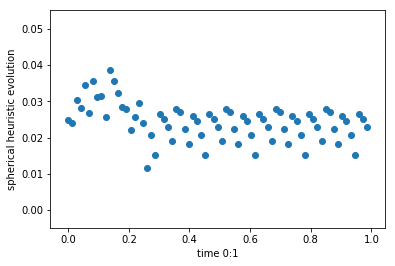

array([6, 4, 0, 1, 2, 3, 5, 7, 8])

In [47]:
s = np.array([0,2,4,6,8,1,3,5,7])

def h_euc(s): # compute heuristic cost using euclidean distance
    
    assert len(s) == len(g)
    
    square_diffs = [(s[i] - g[i])**2 for i in range(len(s))]
    return np.sqrt(sum(square_diffs))

def h_mink(s): # compute heuristic cost using euclidean distance
    
    assert len(s) == len(g)
    
    mink_diffs = [abs(s[i] - g[i]) for i in range(len(s))]
    return sum(mink_diffs)

# evolve_game(s=s, h=h_euc, centered=False, max_budget=20)
evolve_game(s=s, h=h, centered=False, max_budget=75)
# evolve_game(s=s, h=h_mink, max_budget=10, centering=False)

Obviously the initial Greedy optimal path approach needs some iteration to avoid running into loops.

In [ ]:
cost_cache = []
s = np.array([0,2,4,6,8,1,3,5,7])

temp_s = state(s)
print('INITIAL STATE:\n', temp_s)
temp = move_map(temp_s)
costs = evaluate_moves(temp_s, temp, h)
print('MOVES:', temp[0][0] , ' to ', [x[1] for x in temp])
print('COSTS:', costs)
temp_s, cost_cache = select_move(temp_s, temp, costs, cost_cache)



###

print('NEXT STATE:\n', temp_s)
temp = move_map(temp_s)
costs = evaluate_moves(temp_s, temp, h)
print('MOVES:', temp[0][0] , ' to ', [x[1] for x in temp])
print('COSTS:', costs)
temp_s, cost_cache = select_move(temp_s, temp, costs, cost_cache)

###

print('NEXT STATE:\n', temp_s)
temp = move_map(temp_s)
costs = evaluate_moves(temp_s, temp, h)
print('MOVES:', temp[0][0] , ' to ', [x[1] for x in temp])
print('COSTS:', costs)
temp_s, cost_cache = select_move(temp_s, temp, costs, cost_cache)

In [184]:
temp_s[(0,1)]

0

In [146]:
temp_s

array([[6, 0, 4],
       [2, 8, 1],
       [3, 5, 7]])